# Homework

## Problem

Plot the relation between MOHO heat flow density $q$ and MOHO temperature $T$ for range of $q$ from $15$ to $40$ mW/m2. Use the heat production and conductivity same as in the last examples.

## Solution

In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass, field, replace 
from typing import TypeVar, Type, Callable, List, Tuple, Dict, Any

import matplotlib.pyplot as plt

from numpy import array, diag, linspace, ones
from numpy.linalg import solve
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

In [2]:
@dataclass
class state:
    """
    The state of the 1D system pased to the solver.
    """
    H: float = field(metadata={"unit": "W/m^3"})  
    q: float = field(metadata={"unit": "W/m^2"}) 
    k: float = field(metadata={"unit": "W/(m⋅K"})
    n: int   = field()
    d: float = field(metadata={"unit": "m"})

    T: Tuple[float, float] = field(default=(0, 0), metadata={"unit": "°C"})
    
    nodes: array = field(init=False)

    def __post_init__(self) -> None:
        if self.q > 0:
            raise ValueError("The heat flow value must be <= 0!")
        self.nodes = linspace(0, self.d, self.n) 

    @property
    def dx(self) -> float:
        """Get the difference (spacing) between two points."""
        return abs(self.nodes[0] - self.nodes[1])

    def __len__(self) -> int:
        return len(self.nodes)


@dataclass(frozen=True)
class solver1d(ABC):
    """
    The heat equation solver for 1D domain.
    """
    @abstractmethod
    def __call__(self, parameters) -> array:
        """
        Solve the equations and return the solution.
        """


@dataclass(frozen=True)
class heat_1d_exact_solver(solver1d):
    """
    Exact solution of stacionary heat equation in 1D domain.
    """
    def __call__(self, state):
        _ = state
        return -_.H * _.nodes**2 / 2 * _.k + (_.H * _.nodes - _.q) * _.nodes / _.k + _.T[0]


@dataclass(frozen=True)
class heat_1d_fdm_numpy_solver(solver1d):
    """
    The stacionary heat conduction eq. solver for 1D domain with finite difference method using 
    a dense matrix implemented with `numpy`.
    """
    def __call__(self, state) -> array:
        _ = state

        # 1 .Setup the diagonal coefficient matrix `C` and vector `b`.
        C = diag(-2 * ones(len(_)   ),   0) \
          + diag(     ones(len(_) - 1), -1) \
          + diag(     ones(len(_) - 1),  1)
        
        b = ones(len(_)) * (-_.H * _.dx**2) / _.k

        # 2. Setup the boundary condition; DBC at top, NBC at bottom.
        C[0, :2] = [1, 0]
        b[0] = _.T[0]      
        
        C[-1, -2:] = [2, -2]
        b[-1] = (2 * _.q * _.dx - _.H * _.dx**2) / _.k
        
        # 3. Solve the system of equations.
        return solve(C, b)


@dataclass(frozen=True)
class heat_1d_fdm_scipy_solver(solver1d):
    """
    The stacionary heat conduction eq.solver for 1D domain with finite difference method using 
    a sparse matrix implemented with `scipy`.
    """
    def __call__(self, state) -> array:
        _ = state
        
        # 1. Setup the diagonal coefficient matrix `C` and vector `b`. 
        C = spdiags([ones(len(_)), (-2 * ones(len(_))), ones(len(_))], [-1, 0, 1], len(_), len(_), 'csr')
        
        b = ones(len(_)) * (-_.H * _.dx**2) / _.k

        # 2. Setup the boundary condition; DBC at top, NBC at bottom.
        C[0, :2] = [1, 0]
        b[0] = _.T[0]      

        C[-1, -2:] = [2, -2]
        b[-1] = (2 * _.q * _.dx - _.H * _.dx**2) / _.k
        
        # 3. Solve the system of equations.
        return spsolve(C, b)


def plot_temp_vs_depth(xs: array, ts: array):
    fig, axs = plt.subplots(figsize=(10, 10)) 
    axs.set_title("Geotherm")
    axs.set_xlabel("Depth km")
    axs.set_ylabel("Temperature °C")
    axs.plot(ts, xs , "r-")


def plot_heat_flow_vs_temp(qs: array, ts: array):
    plt.figure(figsize=(10, 10))
    plt.plot(qs, ts, 'r-')
    plt.xlabel('Heat Flow mW/m^2')
    plt.ylabel('Temperature °C')    

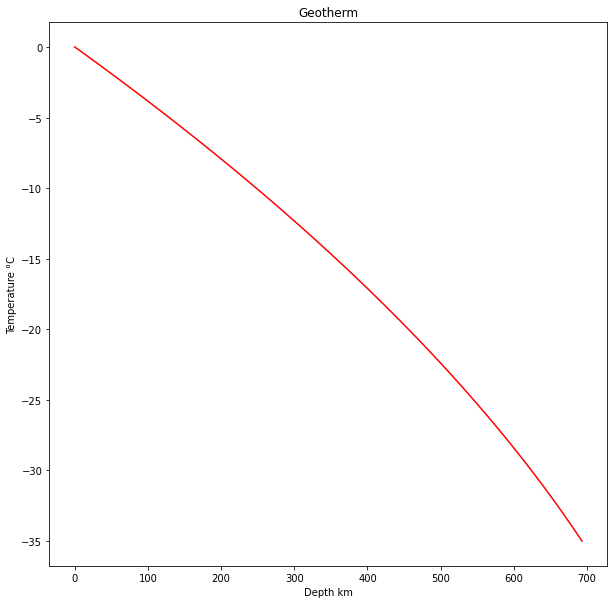

In [5]:
solver = heat_1d_fdm_scipy_solver()

# This is a base reference state, to get a new updated state use the `dataclass.replace()` function.
params = state(d=35_000, n=100, k=2.5, H=1e-6, q=-32e-3, T=(0, 540))

plot_temp_vs_depth(-params.nodes * 1e-3, solver(params))

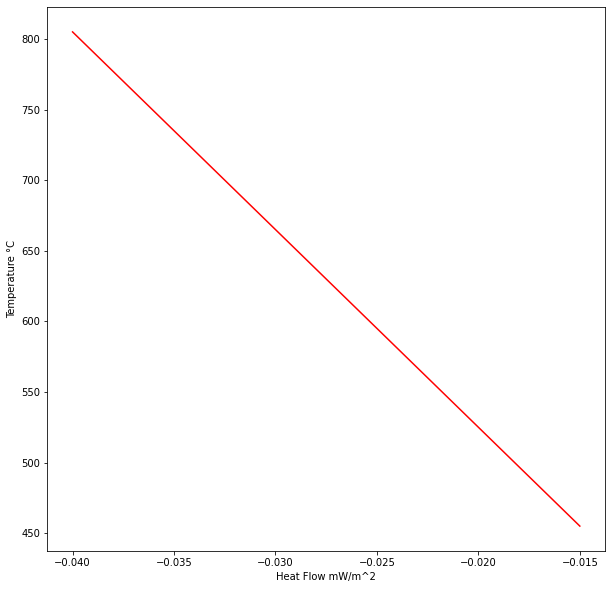

In [8]:
qs = linspace(-15e-3, -40e-3, 100)
ts = [solver(replace(params, q=q)) for q in qs]
plot_heat_flow_vs_temp(qs, [t[-1] for t in ts])

In [9]:
t1, t2, t3 = [[solver(replace(params, H=h, q=q)) for q in qs] for h in (1e-6, 2e-6, 3e-6)]

Text(0.5, 0, 'Heat Flow')

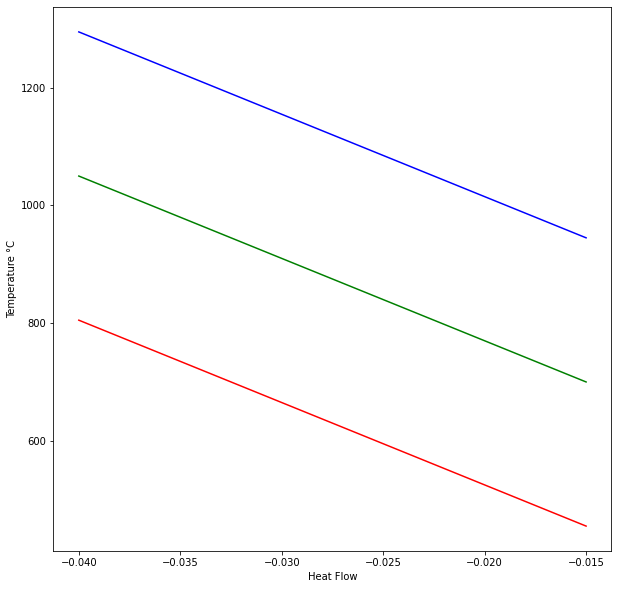

In [10]:
plt.figure(figsize=(10, 10))
# Filter the MOHO (last) temperatures.
plt.plot(qs, [t[-1] for t in t1], 'r-')
plt.plot(qs, [t[-1] for t in t2], 'g-')
plt.plot(qs, [t[-1] for t in t3], 'b-')
plt.ylabel('Temperature °C')    
plt.xlabel('Heat Flow')